In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [3]:
# User specific function 
# org - Original image 
# res - Result image
# resmsg - Resul image heading
def displayimage(org,res,resmsg):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    f.tight_layout()
    ax1.imshow(org)
    ax1.set_title('Original Image', fontsize=15)
    
    ax2.imshow(res, cmap='gray')
    ax2.set_title(resmsg, fontsize=15)
    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Camera Calibrated Successfully for camera_cal/calibration3.jpg
Camera Calibrated Successfully for camera_cal/calibration9.jpg
Camera Calibrated Successfully for camera_cal/calibration12.jpg
Camera Calibrated Successfully for camera_cal/calibration20.jpg
Camera Calibrated Successfully for camera_cal/calibration16.jpg
Camera Calibrated Successfully for camera_cal/calibration13.jpg
Camera Calibrated Successfully for camera_cal/calibration14.jpg
Camera Calibrated Successfully for camera_cal/calibration7.jpg
Camera Calibrated Successfully for camera_cal/calibration2.jpg
Camera Calibrated Successfully for camera_cal/calibration11.jpg
Camera Calibrated Successfully for camera_cal/calibration17.jpg
Camera Calibrated Successfully for camera_cal/calibration19.jpg
Camera Calibrated Successfully for camera_cal/calibration10.jpg
Camera Calibrated Successfully for camera_cal/calibration15.jpg
Camera Calibrated Successfully for camera_cal/calibration8.jpg
Camera Calibrated Successfully for camera_cal

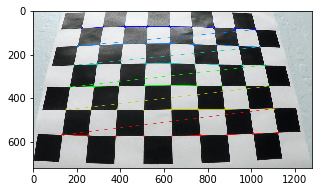

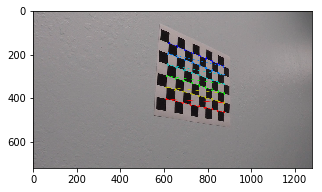

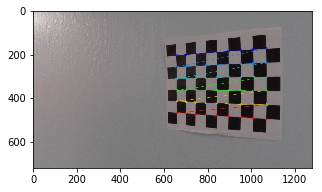

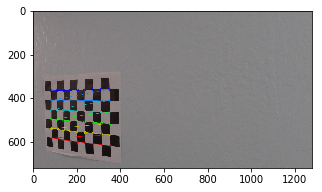

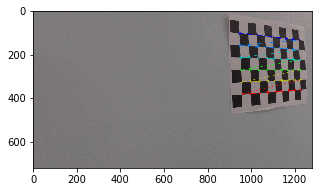

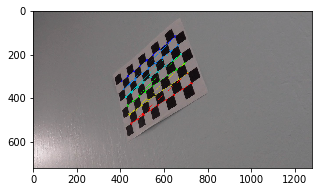

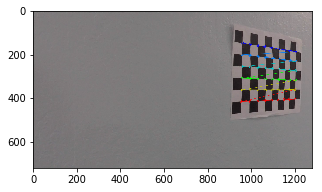

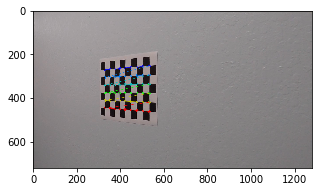

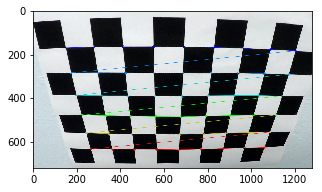

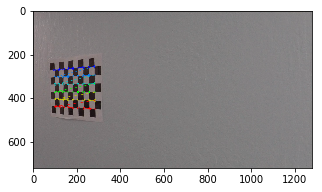

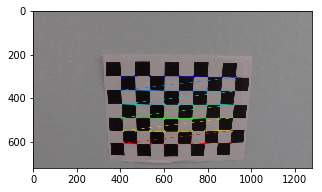

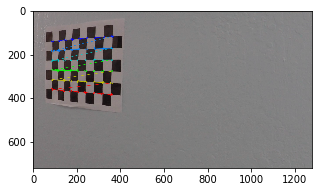

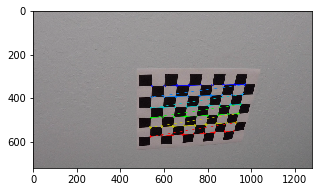

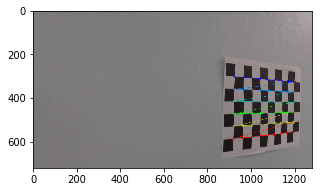

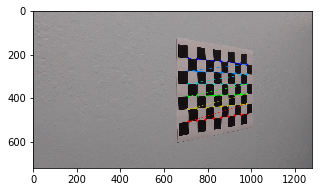

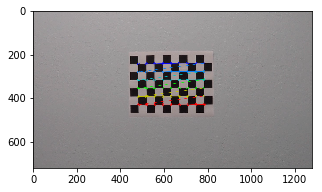

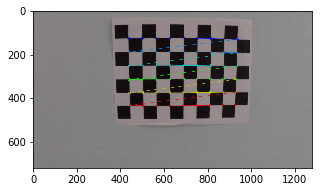

In [4]:
# Number of corners in x 
nx = 9 

# Number of corners in y
ny = 6 

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.

# 3d points in real world space
objpoints = [] 

# 2d points in image plane.
imgpoints = [] 

# Check each image and find the corners 
for image in images:
    img = cv2.imread(image)
    
    # Converting an image to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw detected corners on an image
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        # Plot Images
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        
        print("Camera Calibrated Successfully for " + image)

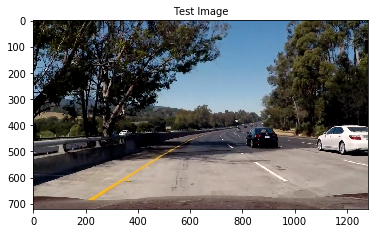

In [5]:
# Get the randon image for testing
testimages = glob.glob('test_images/*.jpg')
choice = np.random.choice(len(testimages))
img = mpimg.imread(testimages[choice])

# Plot Test Image
plt.title('Test Image', fontsize=10)
fig =plt.imshow(img)

In [6]:
def cal_undistort(img, objpoints, imgpoints):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    
    # using CV2 Undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist

Apply a distortion correction to raw images

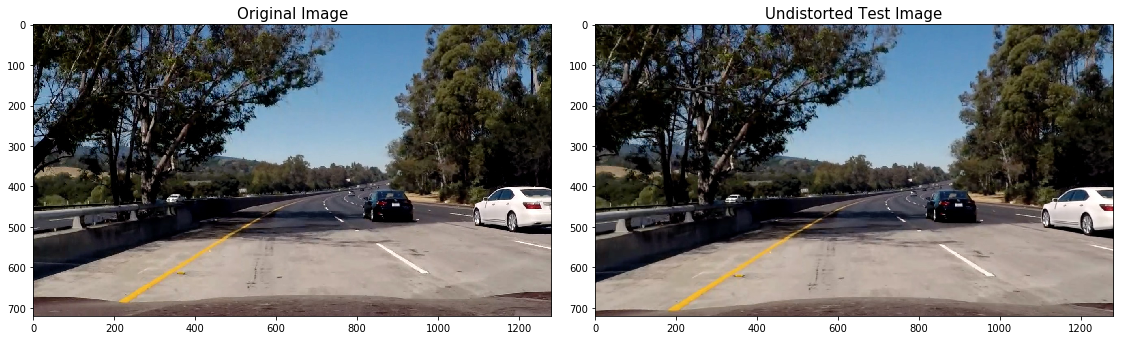

In [7]:
# Verify undistortion for test image
img_undistorted = cal_undistort(img, objpoints, imgpoints)
displayimage(img,img_undistorted,'Undistorted Test Image')

Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").

In [8]:
top_right = (725, 455)
top_left = (555, 455)
botom_right = (1280, 680)
botom_left = (0, 680)

def perspective_transform(img, top_right, top_left, botom_right, botom_left):
        
    # Image dimensions
    img_size = (img.shape[1], img.shape[0])
    w, h = img.shape[1], img.shape[0]
    
    # set source points
    src = np.float32([[top_right],[top_left],[botom_right],[botom_left]])
    
    # set destination points
    dst = np.float32([[w,0],[0,0],[w,h],[0,h]])
    
    # Perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # get inverse matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warp original image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    #return warped image and inverse matrix
    return warped, Minv

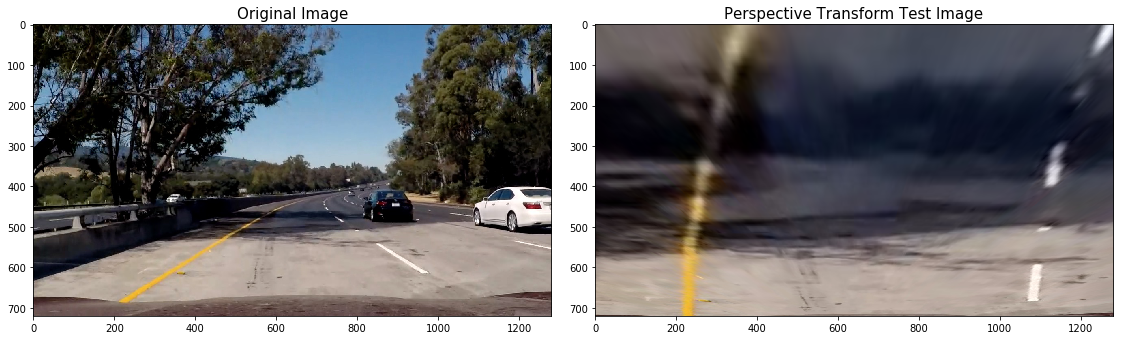

In [9]:
# Verify perspective transform for the test image
img_warped, Minv = perspective_transform(img, top_right,top_left,botom_right, botom_left)
displayimage(img,img_warped,'Perspective Transform Test Image')

Gradient Threshold

In [10]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Use of inclusive (>=, <=) thresholds
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

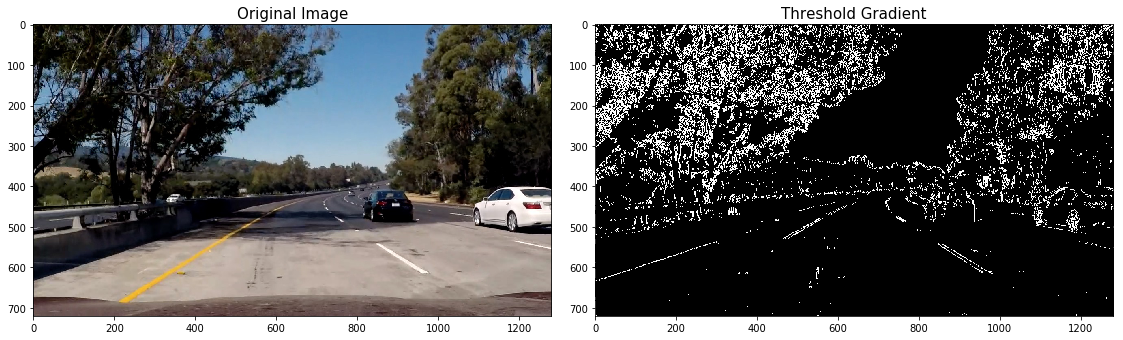

In [11]:
# Verify Gradient thresold for test image
grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
displayimage(img,grad_binary,'Threshold Gradient')

Create Magnitude threshold function

In [12]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    
    # Use of inclusive (>=, <=) thresholds
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

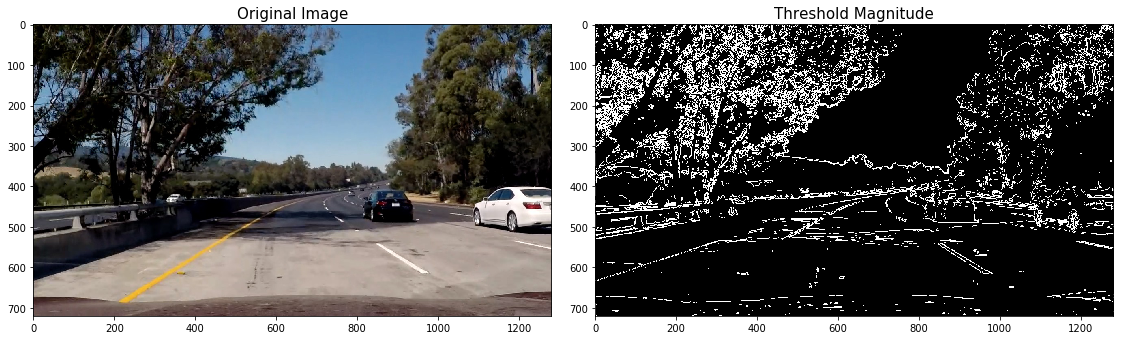

In [13]:
# Verify magnitude threshold for test image
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
displayimage(img,mag_binary,'Threshold Magnitude')

Create direction threshold function

In [14]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    
    # Use of inclusive (>=, <=) thresholds
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

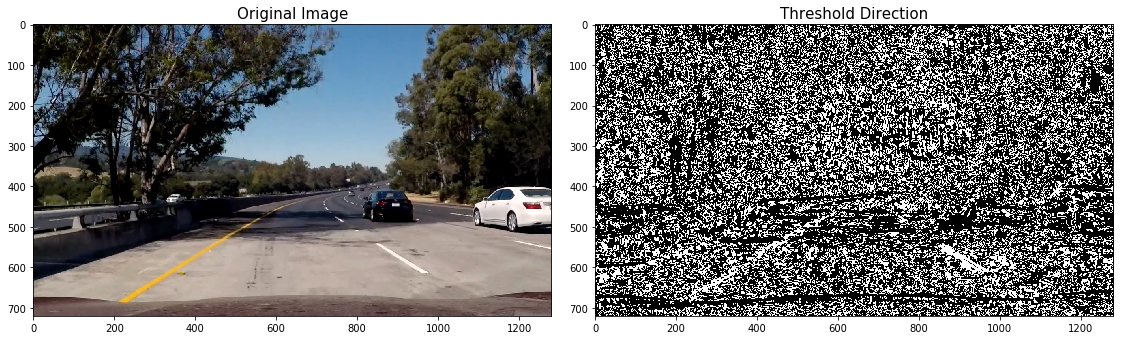

In [15]:
# Verify directional threshold for test image
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
displayimage(img,dir_binary,'Threshold Direction')

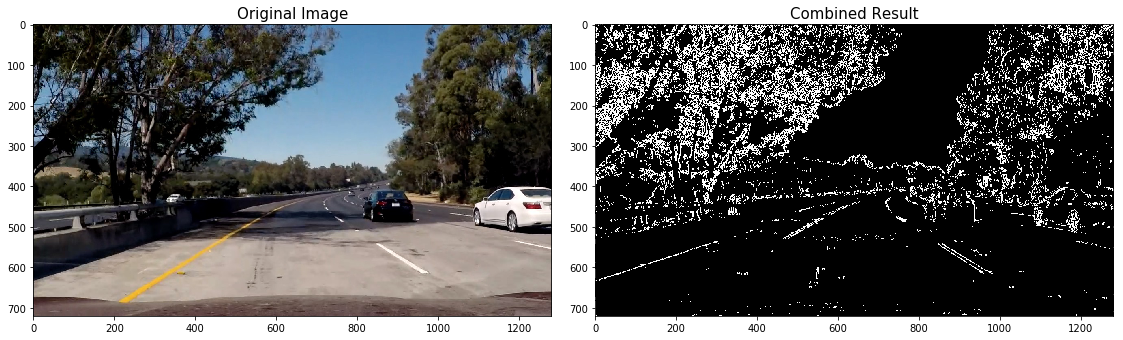

In [16]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
#grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)

mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

#combining results
combined = np.zeros_like(dir_binary)
combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
displayimage(img,combined,'Combined Result')

In [17]:
def hls_select(img, thresh=(0, 255)):
    #converting from RBG to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #S channel
    s_channel = hls[:,:,2]
    
    #creating a binary output using S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

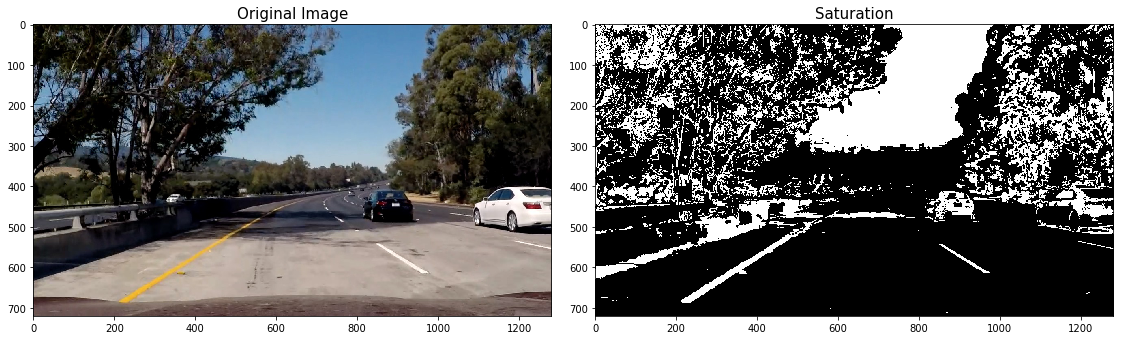

In [18]:
#Verify S channel
hls_binary = hls_select(img, thresh=(90, 255))
displayimage(img,hls_binary,'Saturation')

Color Selection

In [19]:
def color_and_gradient_threshold(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

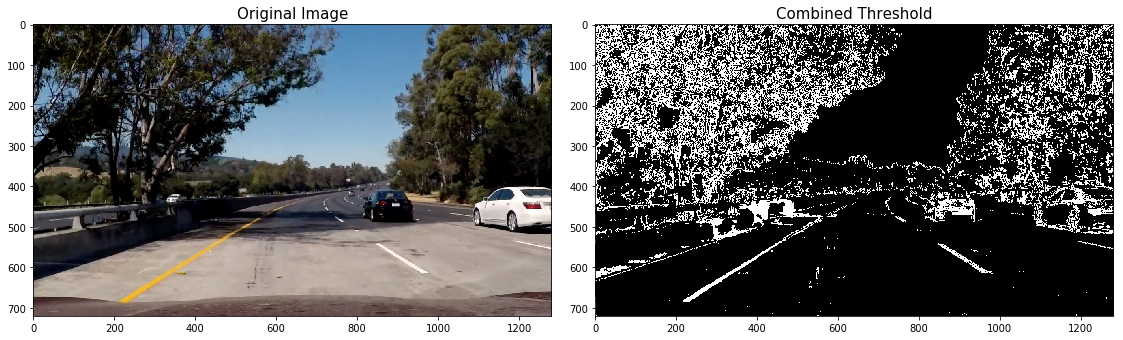

In [20]:
# Verify color and gradient threshold for test image
combined_binary = color_and_gradient_threshold(img)
displayimage(img,combined_binary,'Combined Threshold')

Undistorced Binary Warped Image

In [21]:
def binary(img):
    
    global objpoints
    global imgpoints
    global top_right
    global top_left
    global botom_right
    global botom_left
    
    #Correcting image
    undistorced = cal_undistort(img, objpoints, imgpoints)
    
    #Aplying Thresholds
    color_and_gradient = color_and_gradient_threshold(undistorced)
    
    #Perspective Transform
    result, Minv = perspective_transform(color_and_gradient, top_right, top_left, botom_right, botom_left)
    
    return result, Minv

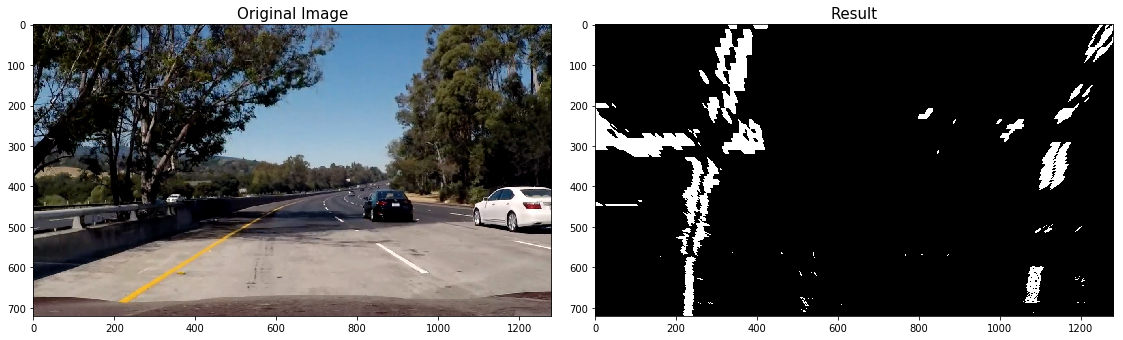

In [22]:
# Verify wraped image 
binary_warped, Minv = binary(img)
displayimage(img,binary_warped,'Result')

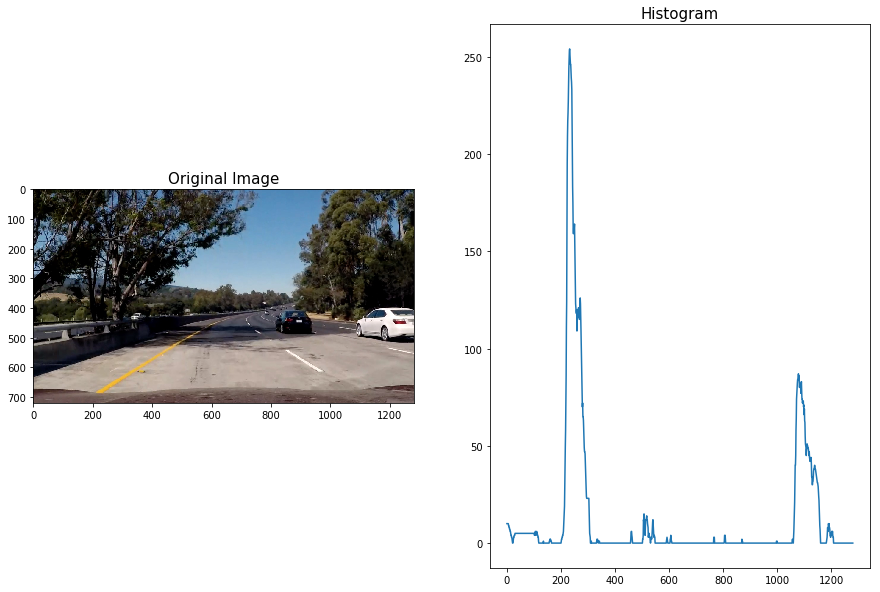

In [23]:
binary_warped, Minv = binary(img)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)

ax2.set_title('Histogram', fontsize=15)
plt.plot(histogram)


Detect lane pixels and fit to find the lane boundary.

In [24]:
def fitpolyline(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # which will be starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    return left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty

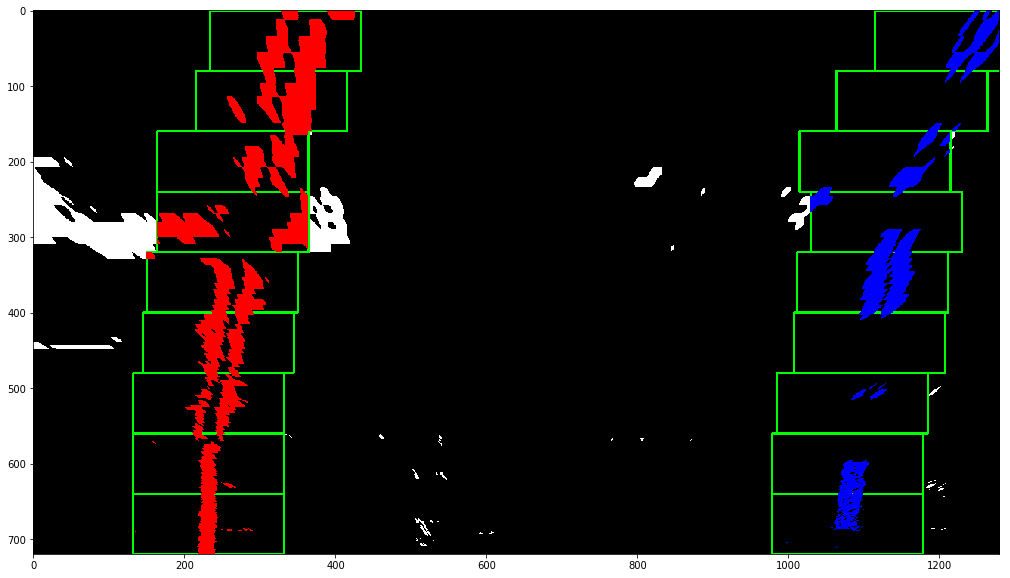

In [25]:
# Testing fitpolyline Function
left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty = fitpolyline(binary_warped)

# Plot Result
plt.figure(figsize=(20,10))
plt.imshow(out_img)

Determine the curvature of the lane and vehicle position with respect to center.

In [26]:
def curvatures(lefty, leftx, righty, rightx, ploty):
    
    # meters per pixel in y dimension
    ym_per_pix = 30/720 
    
    # meters per pixel in x dimension
    xm_per_pix = 3.7/730 
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

In [27]:
# Verify the radius of curvature 
left_curverad, right_curverad = curvatures(lefty, leftx, righty, rightx, ploty)
print(left_curverad, 'mtrs', right_curverad, 'mtrs')

519.978731278 mtrs 390.472448618 mtrs


In [28]:
def draw_lane(img, warped, left_fit, right_fit, ploty, left_curverad, right_curverad, Minv):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Creating Text and set font parameters
    TextL = "Left  Curvature: " + str(int(left_curverad)) + " m"
    TextR = "Right Curvature: " + str(int(right_curverad))+ " m"
    fontScale=1
    thickness=2
    fontFace = cv2.FONT_HERSHEY_SIMPLEX

    # Using CV2 putText to write text into images
    cv2.putText(newwarp, TextL, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, TextR, (110,110), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result

Warp the detected lane boundaries back onto the original image.

In [29]:
def pipeline(img):
    
    # creating a Binary Undistorced Warped Image
    binary_warped, Minv = binary(img)
    
    # Fiting Lines
    left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty = fitpolyline(binary_warped)    
    
    # Calulating the left and right lines curvatures
    left_curverad, right_curverad = curvatures(lefty, leftx, righty, rightx, ploty)
    
    # Draw Lane between road lines
    result_lane = draw_lane(img, binary_warped, left_fit, right_fit, ploty, left_curverad, right_curverad, Minv)

    return result_lane

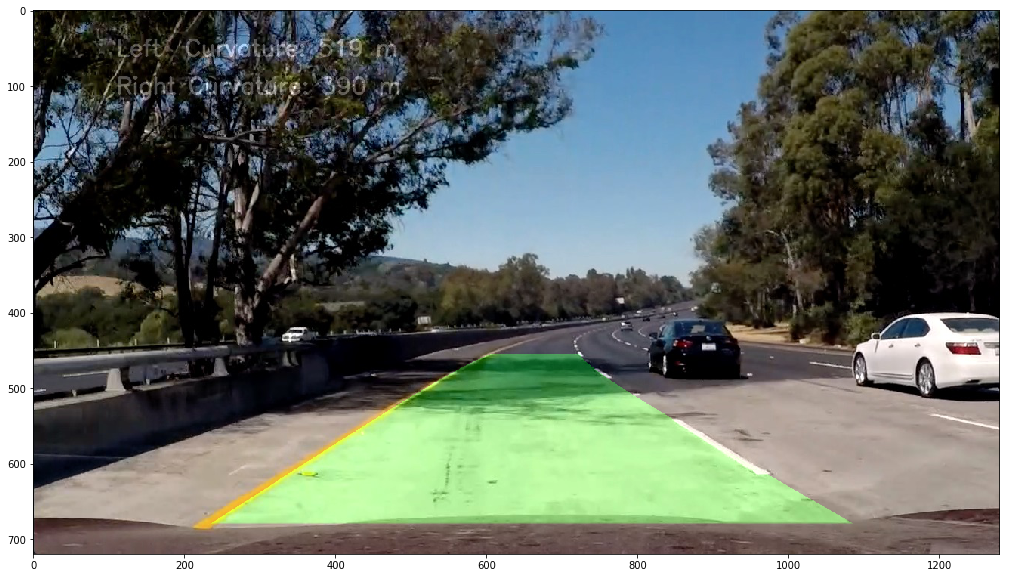

In [30]:
# Verify the function
drawed_lane = draw_lane(img, binary_warped, left_fit, right_fit, ploty, left_curverad, right_curverad, Minv)

# Plot the Result
plt.figure(figsize=(20,10))
plt.imshow(drawed_lane)

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

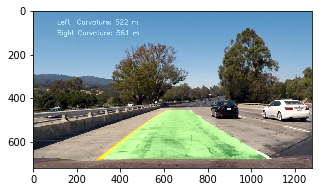

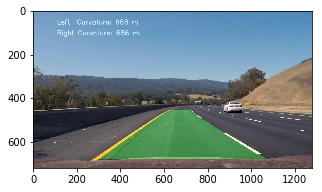

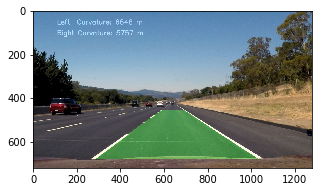

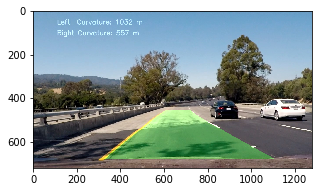

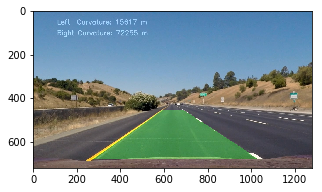

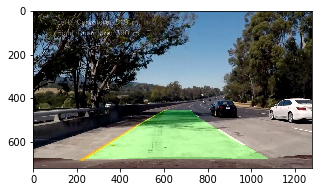

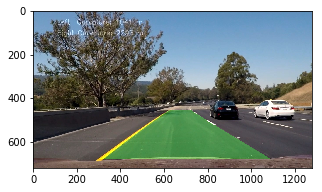

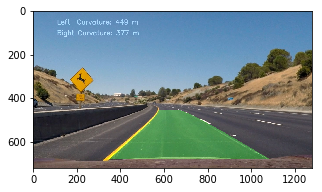

In [31]:
# Verify the pipeline for all the test image 
for image in testimages:
    img = mpimg.imread(image)
    resultado = pipeline(img)
    plt.figure(figsize=(5,5))
    plt.imshow(resultado)

In [35]:
# Verify the pipeline for test video 
output = 'out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(pipeline) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


100%|█████████▉| 1260/1261 [36:08<00:01,  1.79s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 33min 36s, sys: 12 s, total: 33min 48s
Wall time: 36min 11s


In [36]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))